# 3. Neural Network

This notebook is about neural network, especially ANN & DNN, and overfitting. 

**Table of Contents**

**3.1.** [**ANN**](#3.1.-ANN)
    
**3.2.** [**DNN**](#3.2.-DNN)

**3.3.** [**Overfitting**](#3.3-Overfitting)

## 3.1. ANN
인공 신경망 (ANN; Artificial Neural Network)은 인간의 뇌, 혹은 신경계의 작동 방식에서 영감을 받았다. (생물학적 구조를 그대로 따르지는 않음)

신경계가 작동하려면 가장 먼저 눈이나 혀같은 감각 기관을 통해 자극을 입력받아, 이를 처리해 인접한 신경세포로 전달한다. 

인공 신경망에서 자극을 입력받는 감각기관에 해당하는 부분은 입력층 (input layer)가 되고, 입력층을 거친 자극은 은닉층 (hidden layer)를 지나 출력층 (output layer)로 전달된다. 

각 층에 존재하는 한 단위의 인공 neuron을 노드 (node)라고 한다. 

![image](https://user-images.githubusercontent.com/88715406/178668703-2c370945-cc67-47cc-9928-6d0841cf8a61.png)

하나의 생물학적 신경세포는 인접한 세포로 자극을 전달하기 전, 화학적 처리를 거친다고 한다. 

이와 비슷하게 신경망의 각 노드 역시 입력된 자극에 특정한 수학 연산을 실행한다. 

![image](https://user-images.githubusercontent.com/88715406/178669437-4cd8256f-1559-4d20-8b42-76dcb8f36dba.png)

만약 ANN에서 각 층의 노드가 다음 층의 노드와 모두 연결되었다면 (fully connected), 이를 MLP; Mulitlayer Perceptron이라고 부르기도 한다. 

ANN을 구현하여 classification 문제를 해결해보자.

* **import**

Numpy는 행렬과 벡터 연산에 유용한 라이브러리로, PyTorch 역시 numpy를 이용해 개발되었다.

Scikit-learn은 Python의 대표적인 ML 라이브러리로, DL을 제외한 ML은 거의 이 라이브러리를 사용한다. 

matplotlib은 학습 데이터의 분포와 패턴을 시각화하기 위해 사용할 예정이다.

In [8]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

* **Dataset**

Scikit-learn의 make_blobs() method는 예제용 dataset을 만들어주는 함수이다. 이 함수는 실행 때마다 무작위한 dataset을 생성하기 때문에 실행 결과물이 약간씩 다를 수 있다. 

이를 이용해 data를 2차원 vector 형태로 얻을 수 있다.

Training dataset에는 80개, Test dataset에는 20개의 2차원 vector data를 담아줄 것이다. 

make_blobs()이 만들어내는 label $y$들은 각 data 한 점 한 점이 몇 번째 cluster에 속해 있는지 알려주는 index이다. (아래의 코드로 총 4개의 cluster를 만들 예정으로, 모든 data들은 0, 1, 2, 3으로 indexing 되어 있다.)


In [9]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]], shuffle=True, cluster_std=0.3)

더 간단한 모델을 위해, 4개의 cluster를 2개로 합쳐보자. (0, 1 -> 0 / 2, 3 -> 1)

In [10]:
def label_map(y_, from_, to_):
    y = np.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

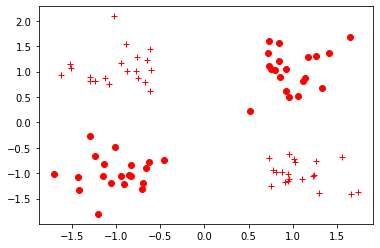

In [11]:
# Visualize data (dot: 0, cross: 1)

def vis_data(x, y=None, c='r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markerredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
plt.figure()
vis_data(x_train, y_train)
plt.show()

In [12]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

* **Implementation**

PyTorch에서 신경망은 보통 다음과 같이 신경망 모듈 torch.nn.Module을 상속받는 class로 정의한다. 이를 상속받으면, PyTorch framework의 다양한 도구를 쉽게 적용할 수 있다. 

**1) __init__()**

Python에서 객체가 갖는 속성값을 초기화하는 역할로, 객체가 생성될 때 자동 호출된다. super() 함수를 호출하면 제작한 class가 nn.Module의 속성을 갖고 초기화된다. 

**2) forward()**

init 함수에서 정의한 동작들을 차례대로 실행한다. 

In [13]:
class ANN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1) # binary
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        linear1 = self.linear_1(x)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        
        return output

model = ANN(2, 5)

* **Set criterion and optimizer**

categorical label이므로, binary cross-entropy를 사용한다. 

In [14]:
learning_rate = 0.03
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 2000

* **Training**

**train(), eval()**

train time과 eval time에 서로 다르게 동작해야 하는 것들이 있다. Dropout, Batchnorm layer 등이 그 예시이다. 

이 method들을 통해 모드를 바꿔줄 수 있고, eval 모드의 경우 이러한 기능들을 turn off 해준다. 

In [15]:
for epoch in range(epochs):
    model.train() # 학습 모드
    optimizer.zero_grad() # optimizer에 연결된 parameter들의 gradient를 0으로 초기화
    
    output = model(x_train)
    
    # checking shape 
    if epoch == 0:
        print('output shape =', output.shape) # output shape = torch.Size([80, 1])
        print('label shape =', y_train.shape) # label shape = torch.Size([80])
    
    # forward pass
    loss = criterion(output.squeeze(), y_train)
    
    # print
    if epoch % 100 == 0:
        print('epoch {}/{}: loss = {}'.format(epoch, epochs, loss))
    
    # backward pass
    loss.backward() # parameter들의 grad를 구해 저장
    optimizer.step() # argument로 전달받았었던 parameter들을 업데이트

output shape = torch.Size([80, 1])
label shape = torch.Size([80])
epoch 0/2000: loss = 0.7208626866340637
epoch 100/2000: loss = 0.6269262433052063
epoch 200/2000: loss = 0.5346444845199585
epoch 300/2000: loss = 0.41530027985572815
epoch 400/2000: loss = 0.29421600699424744
epoch 500/2000: loss = 0.20246902108192444
epoch 600/2000: loss = 0.14256669580936432
epoch 700/2000: loss = 0.10491647571325302
epoch 800/2000: loss = 0.08065199851989746
epoch 900/2000: loss = 0.06432382762432098
epoch 1000/2000: loss = 0.052869074046611786
epoch 1100/2000: loss = 0.04450489580631256
epoch 1200/2000: loss = 0.03819410875439644
epoch 1300/2000: loss = 0.033301420509815216
epoch 1400/2000: loss = 0.029423940926790237
epoch 1500/2000: loss = 0.02628326043486595
epoch 1600/2000: loss = 0.023696294054389
epoch 1700/2000: loss = 0.02153337374329567
epoch 1800/2000: loss = 0.019701948389410973
epoch 1900/2000: loss = 0.018133999779820442


* **Evaluation**


In [16]:
model.eval()
output_test = model(x_test)
loss_test = criterion(output_test.squeeze(), y_test)

print('Test loss = {}'.format(loss_test))

Test loss = 0.02826281264424324


## 3.2. DNN 
ANN에서 은닉층을 깊게 쌓아 더욱 복잡한 모델을 만들어 성능을 향상시킬 수 있다. (그렇다고 무조건적으로 쌓는 것이 항상 성능을 향상시키는 것은 아니다.)

DNN; Deep Neural Network는 입력층과 출력층 사이에 여러 개의 은닉층들로 이루어진 ANN을 의미한다.
![image](https://user-images.githubusercontent.com/88715406/178687097-4f4e5264-b5b5-4625-a7c0-da6d2cefcda0.png)

Fashion MNIST dataset을 분류하는 딥러닝 모델을 구현해보자. 

* **Fashion MNIST Dataset**

28 X 28 pixel 70000개의 흑백 이미지로 구성되며 신발, 드레스, 가방 등 총 10가지 category가 존재한다. 

![image](https://user-images.githubusercontent.com/88715406/178686833-beea3e63-12ef-4b98-82de-3e94f4555089.png)

**1) torch.utils.data**

Dataset을 불러오고 자르거나 섞는 등의 도구가 들어있는 모듈이다. 
PyTorch 모델을 학습시키기 위한 dataset의 표준을 torch.utils.data.Dataset에 정희해준다. 
Dataset 모듈을 상속하는 자식 class는 학습에 필요한 data를 로딩해주는 torch.utils.data.DataLoader 인스턴스의 입력으로 사용할 수 있다.

**2) torchvision.datasets**

torch.utils.data.Dataset을 상속하는 이미지 dataset의 모음으로, Fashion MNIST가 바로 여기에 들어있다. 

**3) torchvision.transforms**

이미지 dataset에 쓸 수 있는 여러 변환 필터가 존재한다. (resize, crop, brightness, contrast, ...)

**4) torchvision.utils**

이미지 data를 저장하고 시각화하기 위한 도구가 들어있는 모듈이다. 

In [17]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

먼저 transform은 이미지를 텐서로 바꿔준다. torchvision.transforms의 ToTensor()를 이용하면 된다. 

Dataset은 torchvision.datasets 패키지를 통해 불러온다. 또한 불러오면서 transform을 바로 적용해줄 수 있다.
(download=True를 통해 현재 root로 지정한 폴더에 dataset이 존재하는지 확인 후 없다면 자동으로 저장된다.)

In [18]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transform
)

torch.utils.data의 DataLoader는 dataset을 batch로 조개고 학습 시 반복문 안에서 data를 공급해주는 class이다.

In [19]:
batch_size = 64

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

* **DataLoader**

iter() 함수를 이용하면 data를 반복문 안에서 이용할 수 있도록 만들 수 있다. 그 후 next()를 이용해 배치 1개를 가져올 수 있다. 

In [20]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(images[1].shape) # 1x28x28 image

torch.Size([1, 28, 28])


torchvision의 utils.make_grid() 함수를 이용해 여러 이미지를 모아 하나로 만들 수 있다. 

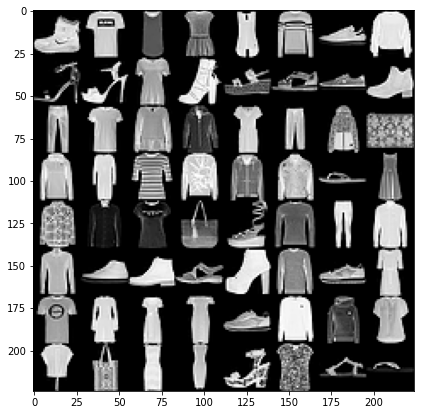

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


In [21]:
img = utils.make_grid(images, padding=0) # torch tensor
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt는 차원 인식 순서가 다르므로, channel 차원을 맨 뒤로 보낸다.
plt.show()
print(labels)

index만으로 label을 알기 힘드므로, index와 label을 mapping하는 dictionary를 만들어보자.

In [22]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

* **Implementation**

In [23]:
import torch
import torch.nn as nn # class로 구현되어 있음 
import torch.nn.functional as F # function
import torch.optim as optim

In [24]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

True


'nvcc'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [25]:
EPOCHS = 30
BATCH_SIZE = batch_size

In [34]:
class FashionDNN(nn.Module): # DNN for FashionMNIST
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        out1 = F.relu(self.fc1(x))
        out2 = F.relu(self.fc2(out1))
        out = self.fc3(out2)
        return F.softmax(out, dim=1)
    
model = FashionDNN().to(DEVICE)

* **Set optimizer**

loss는 F 모듈을 이용할 것이다. 

In [27]:
optimizer = optim.SGD(model.parameters(), lr = 0.01) 

* **Training**

앞선 예제에서는 label이 2개였으므로 BCE를 사용했으나, 이번 예제의 경우 label이 10개이므로, F.cross_entropy()를 사용한다.

In [28]:
def train(model, train_loader, optimizer):
    model.train() # train mode
    
    for batch_idx, (x_train, y_train) in enumerate(train_loader):
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE) # batch_size X 1 X 28 X 28
        
        optimizer.zero_grad()
        output = model(x_train)
        loss = F.cross_entropy(output, y_train)
        
        loss.backward()
        optimizer.step()

* **Evaluating**

Fashion MNIST는 규모가 작아 train & test 2가지로 나뉘어져 있으나, 대부분의 dataset은 train / validation / test 3가지로 나뉜다.

train은 가중치를 조절하고, validation은 batch size와 learning rate, model layer의 종류와 size 등의 **hyperparameter**를 조절하기 위한 과정이며 test는 최종 성능 보고를 위한 과정이다. 

In [29]:
def evaluate(model, test_loader):
    model.eval() # evaluate mode

    # initialize
    test_loss = 0 
    correct = 0
    
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
            output = model(x_test)
            
            # reduction: mean/sum will be applied to the output.
            test_loss += F.cross_entropy(output, y_test, reduction='sum').item()
            
            pred = output.argmax(axis=1, keepdims=True)
            correct += pred.eq(y_test.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_acc

In [30]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_acc = evaluate(model, test_loader)
    
    print('Epochs {}/{}: loss {:.4f} acc {:2f}%'.format(epoch, EPOCHS, test_loss, test_acc))

Epochs 1/30: loss 2.2912 acc 41.150000%
Epochs 2/30: loss 2.2500 acc 45.290000%
Epochs 3/30: loss 2.0160 acc 52.940000%
Epochs 4/30: loss 1.9273 acc 55.560000%
Epochs 5/30: loss 1.8667 acc 62.380000%
Epochs 6/30: loss 1.8233 acc 66.390000%
Epochs 7/30: loss 1.7923 acc 70.450000%
Epochs 8/30: loss 1.7667 acc 73.580000%
Epochs 9/30: loss 1.7452 acc 75.150000%
Epochs 10/30: loss 1.7294 acc 75.940000%
Epochs 11/30: loss 1.7182 acc 76.490000%
Epochs 12/30: loss 1.7101 acc 76.940000%
Epochs 13/30: loss 1.7041 acc 77.300000%
Epochs 14/30: loss 1.6993 acc 77.650000%
Epochs 15/30: loss 1.6953 acc 77.850000%
Epochs 16/30: loss 1.6921 acc 78.090000%
Epochs 17/30: loss 1.6893 acc 78.200000%
Epochs 18/30: loss 1.6869 acc 78.290000%
Epochs 19/30: loss 1.6848 acc 78.490000%
Epochs 20/30: loss 1.6830 acc 78.610000%
Epochs 21/30: loss 1.6813 acc 78.750000%
Epochs 22/30: loss 1.6797 acc 78.850000%
Epochs 23/30: loss 1.6782 acc 79.010000%
Epochs 24/30: loss 1.6767 acc 79.200000%
Epochs 25/30: loss 1.6754

## 3.3 Overfitting

ML 모델을 만들면 training 성능은 좋지만 test 성능 또는 실제 상황에서 좋은 성능을 내지 못하는 경우가 있다. 이를 과적합 Overfitting이라고 한다. 

Training dataset에만 익숙해져 모델의 유연성이 부족해지는 현상이라고 말할 수 있다. 

반대로 training을 제대로 진행하지 않아 training 성능조차 뛰어나지 않은 상황을 과소적합 Underfitting이라고 한다. 

이를 해결하는 방법 중 일부들을 알아보자.

![image](https://user-images.githubusercontent.com/88715406/178883749-d13ae37d-d404-4f14-981e-5db601906cf1.png)

**1) Data augmentation**

Overfitting을 방지하는 이상적인 방법은 존재하는 모든 data를 모아 모델을 학습시키는 것이다. 하지만 이는 불가능하므로,

이미 가진 data를 최대한 늘리는 방법 (이미지의 경우 일부를 자르거나 회전, 색 반전 등)인 data augmentation을 통해 모델의 유연성을 늘릴 수 있다. 

In [31]:
EPOCHS = 50
BATCH_SIZE = 64

train_loader = data.DataLoader(
    datasets.MNIST('./data',
                  train=True,
                  download=True,
                  transform=transforms.Compose([
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081, ))
                  ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = data.DataLoader(
    datasets.MNIST('./data',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081, ))
                  ])),
    batch_size=BATCH_SIZE, shuffle=True)

**2) Dropout**

Data가 아닌 모델 자체에 영향을 주어 해결할 수도 있다. 그 중 대표적인 것이 Dropout이다.

Dropout은 학습 과정에서 신경망의 일부를 사용하지 않는 방법이다. (검증, 테스트 단계에서는 그대로 진행)

학습에서 배제된 neuron 외에 다른 neuron들에게 가중치를 분산시키고 각 neuron이 특징에 고정되는 현상을 방지하는 효과가 있다. 

![image](https://user-images.githubusercontent.com/88715406/178894715-8e8883b8-20e4-4447-85c7-a58ab804b3f7.png)

In [32]:
class FashionDNN(nn.Module): # DNN for FashionMNIST
    def __init__(self, p = 0.2):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout_p = p
        
    def forward(self, x):
        x = x.view(-1, 784)
        out1 = F.relu(self.fc1(x))
        out1 = F.dropout(out1, training=self.training, p=self.dropout_p)
        out2 = F.relu(self.fc2(out1))
        out2 = F.dropout(out2, training=self.training, p=self.dropout_p)
        out = self.fc3(out2)
        return F.softmax(out, dim=1)
    
model = FashionDNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr = 0.01) 

In [33]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_acc = evaluate(model, test_loader)
    
    print('Epochs {}/{}: loss {:.4f} acc {:2f}%'.format(epoch, EPOCHS, test_loss, test_acc))

Epochs 1/50: loss 2.2376 acc 36.960000%
Epochs 2/50: loss 1.9123 acc 62.070000%
Epochs 3/50: loss 1.8302 acc 64.170000%
Epochs 4/50: loss 1.7701 acc 70.810000%
Epochs 5/50: loss 1.7517 acc 71.610000%
Epochs 6/50: loss 1.6851 acc 79.730000%
Epochs 7/50: loss 1.6686 acc 80.570000%
Epochs 8/50: loss 1.6604 acc 80.980000%
Epochs 9/50: loss 1.6549 acc 81.330000%
Epochs 10/50: loss 1.6510 acc 81.640000%
Epochs 11/50: loss 1.6484 acc 81.880000%
Epochs 12/50: loss 1.6444 acc 82.340000%
Epochs 13/50: loss 1.6415 acc 82.640000%
Epochs 14/50: loss 1.6376 acc 82.970000%
Epochs 15/50: loss 1.6357 acc 83.140000%
Epochs 16/50: loss 1.6333 acc 83.310000%
Epochs 17/50: loss 1.6314 acc 83.420000%
Epochs 18/50: loss 1.6303 acc 83.560000%
Epochs 19/50: loss 1.6273 acc 83.830000%
Epochs 20/50: loss 1.6250 acc 84.030000%
Epochs 21/50: loss 1.6237 acc 84.250000%
Epochs 22/50: loss 1.6218 acc 84.340000%
Epochs 23/50: loss 1.6200 acc 84.580000%
Epochs 24/50: loss 1.6188 acc 84.640000%
Epochs 25/50: loss 1.6168